In [6]:
# ==============================
# 0. Imports
# ==============================
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import (
    SelectKBest,
    mutual_info_regression,
    SelectFromModel
)
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor


In [7]:
# -------- 1. Load data --------
train = pd.read_csv("processed_data/train_unscaled.csv")
val   = pd.read_csv("processed_data/val_unscaled.csv")
test  = pd.read_csv("processed_data/test_unscaled.csv")

print("Train shape:", train.shape)
print("Val shape  :", val.shape)
print("Test shape :", test.shape)

target_col = "price"
feature_cols = [c for c in train.columns if c != target_col]

X_train = train[feature_cols]
y_train = train[target_col]

X_val   = val[feature_cols]
y_val   = val[target_col]

X_test  = test[feature_cols]
y_test  = test[target_col]

print("\nExample features:")
display(X_train.head())
print("\nTarget stats (train):")
print(y_train.describe())


Train shape: (12016, 103)
Val shape  : (4006, 103)
Test shape : (4006, 103)

Example features:


,host_response_rate,host_listings_count,host_total_listings_count,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,...,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_60,host_name_target_encoded,host_location_target_encoded,host_neighbourhood_target_encoded,neighbourhood_target_encoded,neighbourhood_cleansed_target_encoded,property_type_target_encoded
0,1.00,1.0,1.0,52.380421,4.885986,1,2,1.0,1.0,1.0,...,1,0,0,0,140.000000,149.644507,182.085595,190.842308,191.340714,146.933824
1,1.00,1.0,1.0,52.354774,4.887776,1,2,1.0,1.0,1.0,...,1,1,0,0,121.444444,149.644507,155.860795,159.358316,155.564050,146.933824
2,1.00,1.0,1.0,52.381446,4.852645,1,4,1.0,2.0,2.0,...,1,1,0,0,156.500000,149.280319,118.687964,117.911145,118.138129,146.933824
3,1.00,1.0,1.0,52.379647,4.889621,1,2,1.0,2.0,2.0,...,1,0,1,0,190.000000,171.687368,190.843662,207.379765,191.340714,146.933824
4,0.99,38.0,38.0,52.374279,4.857828,1,2,1.0,1.0,1.0,...,1,1,0,0,168.094340,149.280319,144.124297,141.762177,144.540164,146.933824



Target stats (train):
count    12016.000000
mean       153.443326
std        156.034610
min          8.000000
25%         97.000000
50%        125.000000
75%        175.000000
max       8500.000000
Name: price, dtype: float64


In [8]:
df = pd.read_csv("processed_data/train_unscaled.csv")


In [9]:
print(df.columns)

Index(['host_response_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude',
       'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       ...
       'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_60', 'host_name_target_encoded',
       'host_location_target_encoded', 'host_neighbourhood_target_encoded',
       'neighbourhood_target_encoded', 'neighbourhood_cleansed_target_encoded',
       'property_type_target_encoded', 'price'],
      dtype='object', length=103)


In [10]:
#Feature Engineering

In [11]:
CITY_LAT = 52.3676
CITY_LON = 4.9041

df["dist_to_center"] = np.sqrt(
    (df["latitude"] - CITY_LAT)**2 +
    (df["longitude"] - CITY_LON)**2
)

# ---- Amsterdam Central Station ----
CENTRAL_LAT = 52.3791
CENTRAL_LON = 4.8994

df["dist_to_central_station"] = np.sqrt(
    (df["latitude"] - CENTRAL_LAT)**2 +
    (df["longitude"] - CENTRAL_LON)**2
)

# ---- Rijksmuseum (52.3600° N, 4.8852° E) ----
RIJK_LAT = 52.3600
RIJK_LON = 4.8852

df["dist_to_rijksmuseum"] = np.sqrt(
    (df["latitude"] - RIJK_LAT)**2 +
    (df["longitude"] - RIJK_LON)**2
)

# ---- Vondelpark (52.3580° N, 4.8686° E) ----
VONDEL_LAT = 52.3580
VONDEL_LON = 4.8686

df["dist_to_vondelpark"] = np.sqrt(
    (df["latitude"] - VONDEL_LAT)**2 +
    (df["longitude"] - VONDEL_LON)**2
)

# ---- Schiphol Airport (52.3128° N, 4.7402° E) ----
SCHIPHOL_LAT = 52.3128
SCHIPHOL_LON = 4.7402

df["dist_to_schiphol"] = np.sqrt(
    (df["latitude"] - SCHIPHOL_LAT)**2 +
    (df["longitude"] - SCHIPHOL_LON)**2
)

print("Added location-based features:",
      ["dist_to_center",
       "dist_to_central_station",
       "dist_to_rijksmuseum",
       "dist_to_vondelpark",
       "dist_to_schiphol"])

Added location-based features: ['dist_to_center', 'dist_to_central_station', 'dist_to_rijksmuseum', 'dist_to_vondelpark', 'dist_to_schiphol']


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")



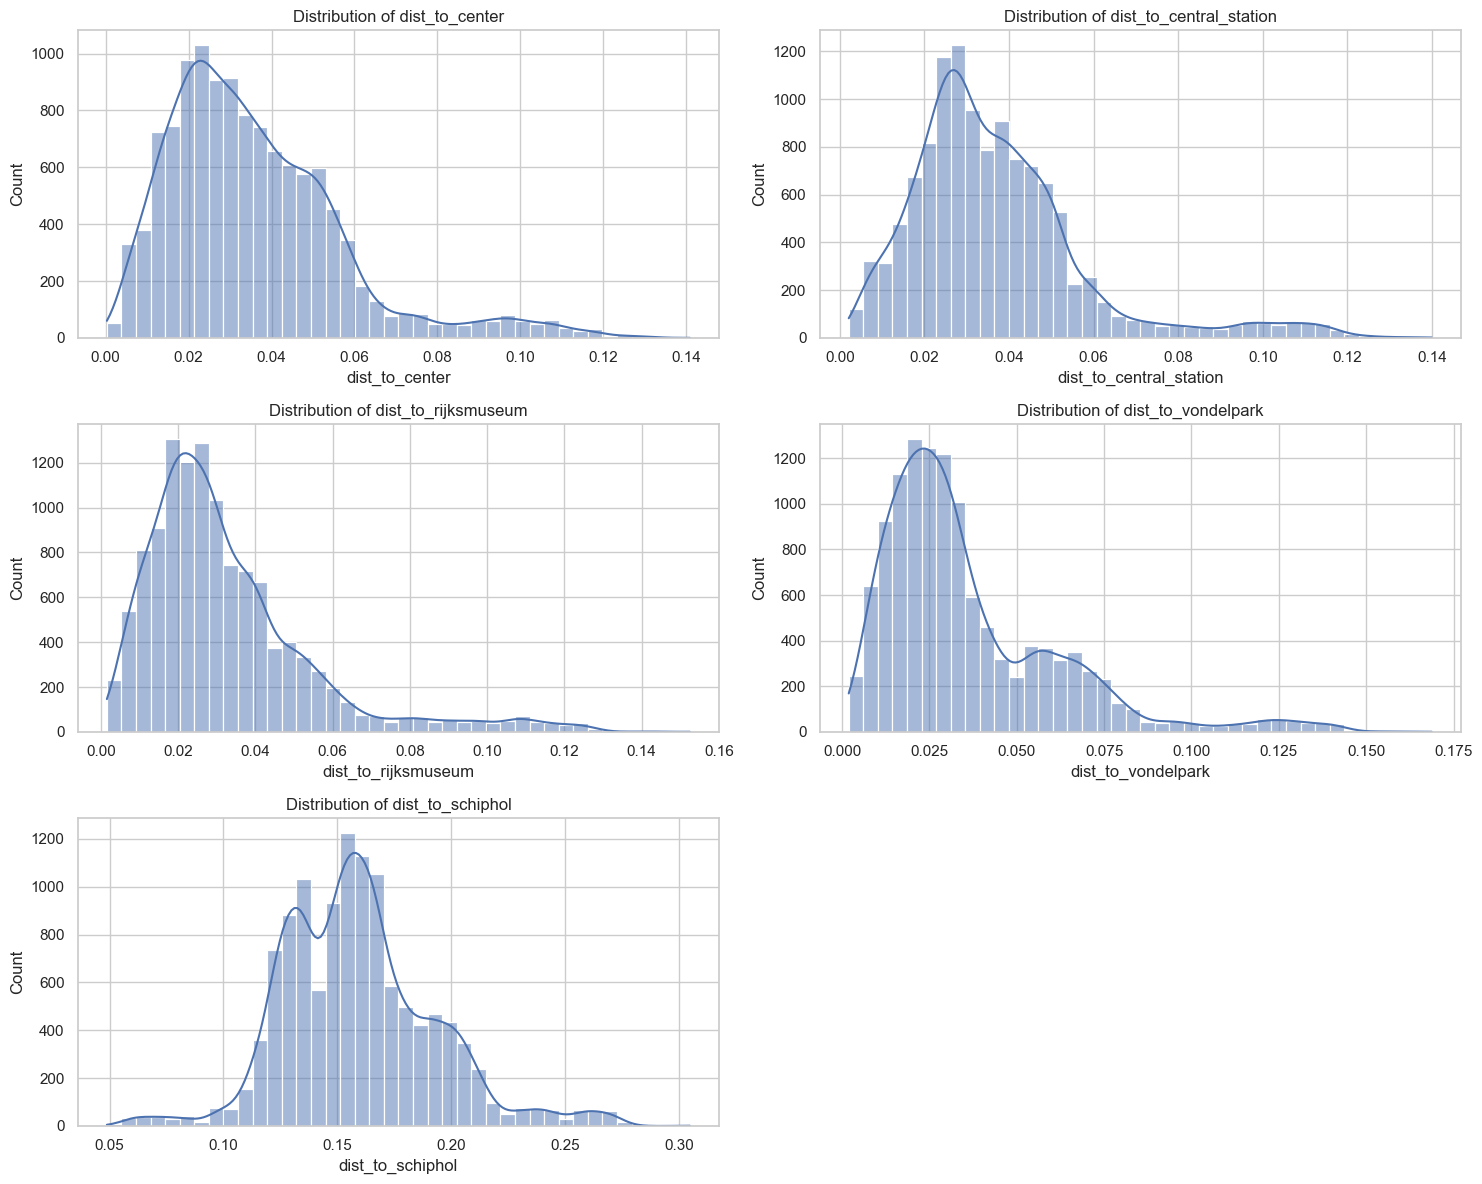

In [13]:
# List of new engineered features
loc_features = [
    "dist_to_center",
    "dist_to_central_station",
    "dist_to_rijksmuseum",
    "dist_to_vondelpark",
    "dist_to_schiphol"
]

plt.figure(figsize=(15, 12))

for i, col in enumerate(loc_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


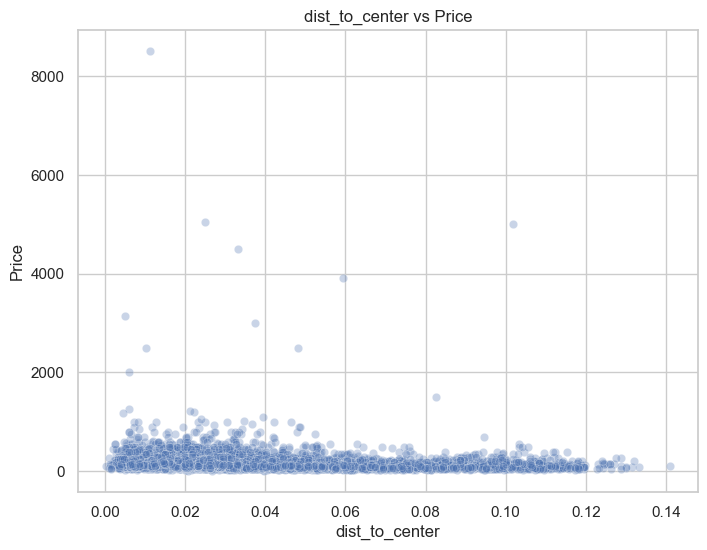

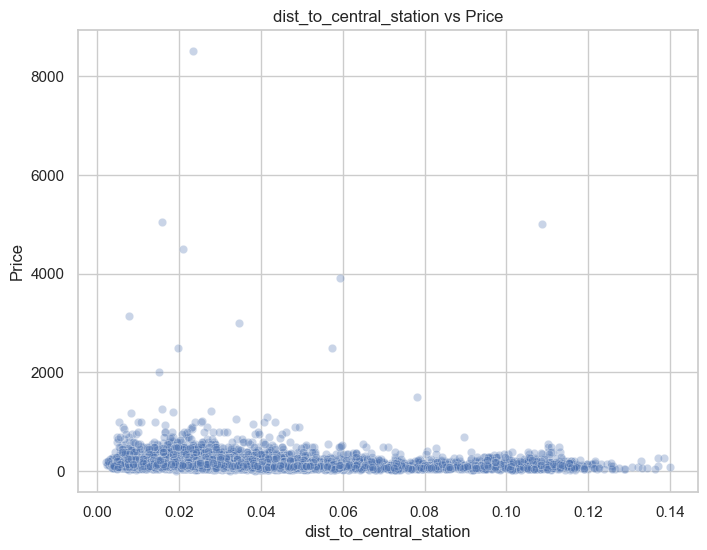

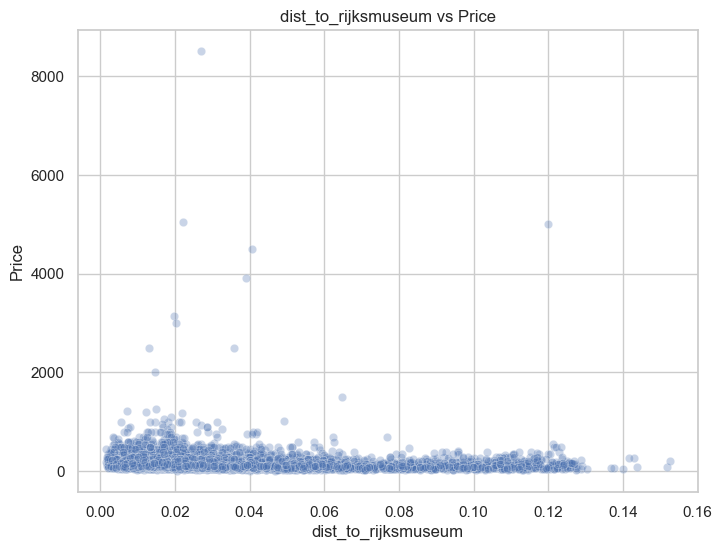

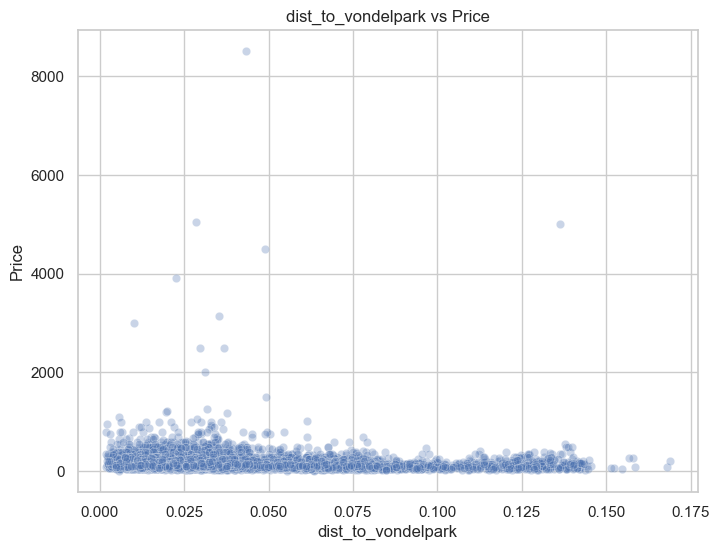

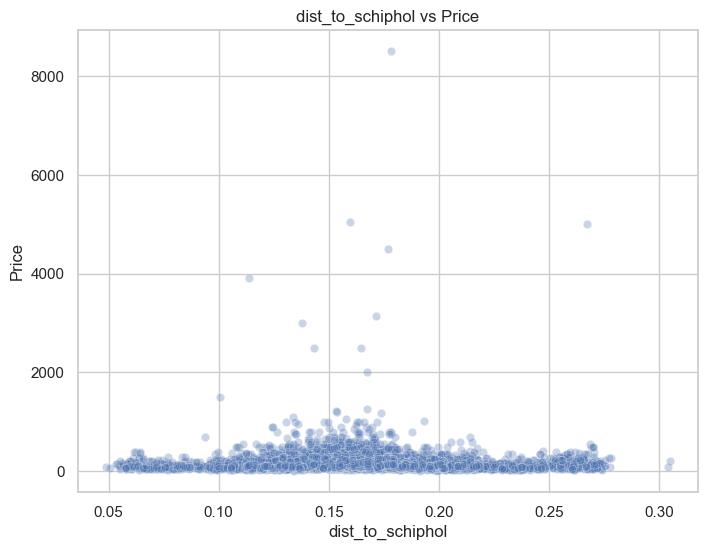

In [14]:
for col in loc_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col, y="price", alpha=0.3)
    plt.title(f"{col} vs Price")
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.show()


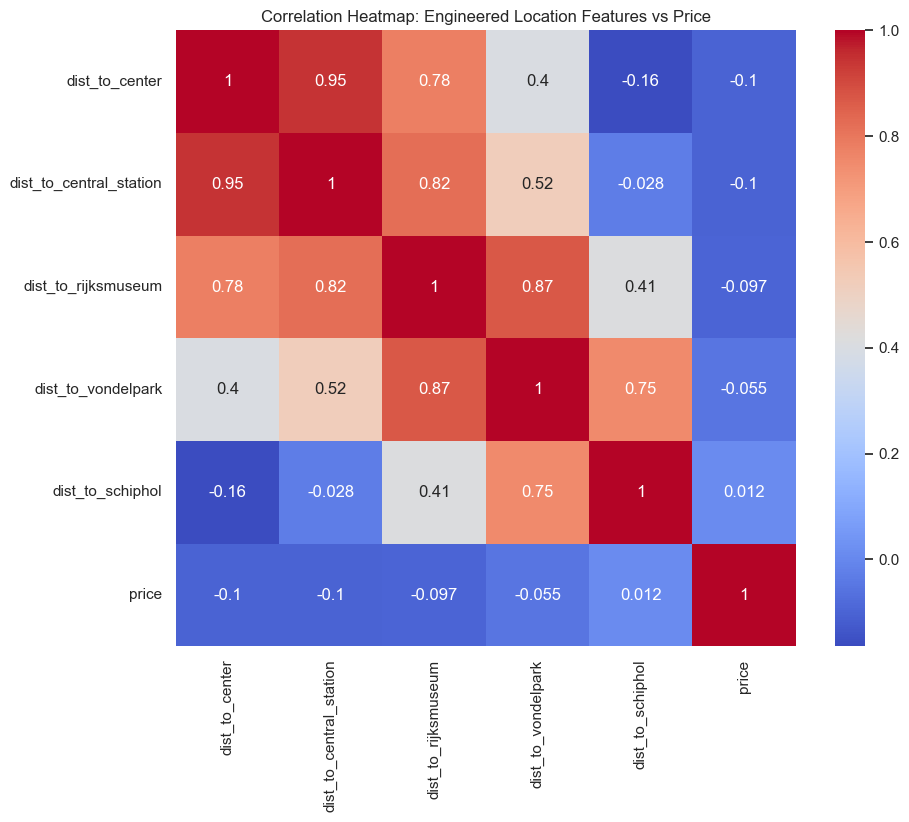

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[loc_features + ["price"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap: Engineered Location Features vs Price")
plt.show()


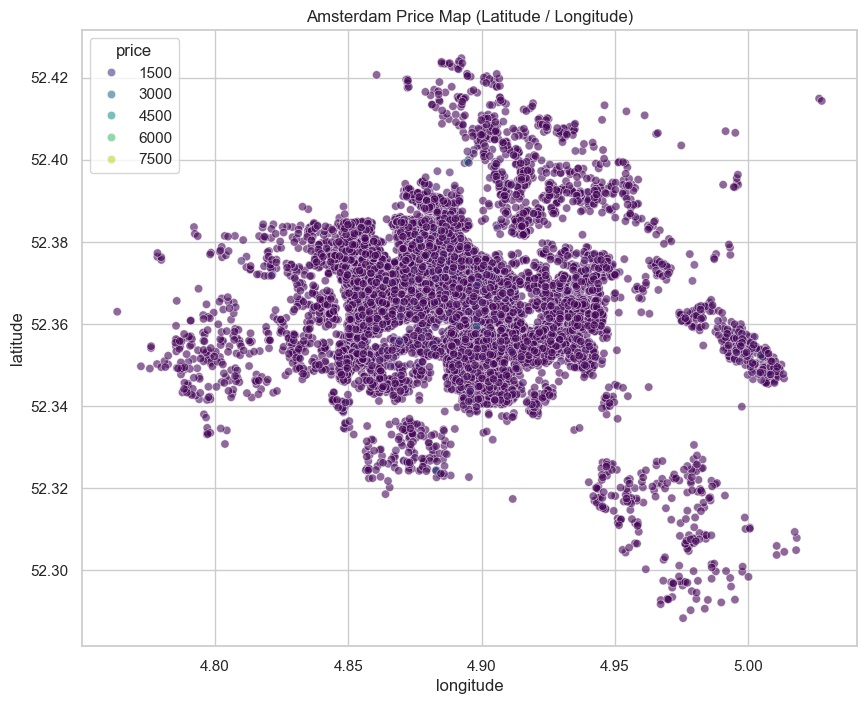

In [16]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x="longitude",
    y="latitude",
    hue="price",
    palette="viridis",
    alpha=0.6
)
plt.title("Amsterdam Price Map (Latitude / Longitude)")
plt.show()


In [17]:
import os
os.listdir()


['.git',
 '.gitignore',
 '.idea',
 '.venv',
 'almostengineers_data_cleaning.ipynb',
 'Emin_models',
 'Emin_plots',
 'EMİN_HALLAK_22040301163_almostengineers.ipynb',
 'EMİN_HALLAK_22040301163_almostengineers_plots',
 'FADILA_HACHACH_22040101149_almostengineers.ipynb',
 'FADILA_HACHACH_22040101149_almostengineers_plots',
 'feature_importance_rankings.csv',
 'LİLAS_MUHAMMED_22040101014_almostengineers.ipynb',
 'LİLAS_MUHAMMED_22040101014_almostengineers_plots',
 'MUSAAB_ALTAWEEL_22040101160_almostengineers.ipynb',
 'MUSAAB_ALTAWEEL_22040101160_almostengineers_plots',
 'processed_data',
 'README.md',
 '__pycache__']

In [18]:
ridge_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectFromModel(Lasso(alpha=0.001))),
    ("pca", PCA(n_components=20)),
    ("model", Ridge())
])


In [19]:
gbr_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("select", SelectFromModel(Lasso(alpha=0.001))),
    ("model", GradientBoostingRegressor(random_state=42))
])


In [20]:
svr_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectFromModel(Lasso(alpha=0.001))),
    ("pca", PCA(n_components=20)),
    ("model", SVR())
])


# ExtraTrees Pipeline
extratrees_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", ExtraTreesRegressor(n_estimators=100, random_state=42))
])

# Stacking Pipeline with Ridge, GBR, and ExtraTrees as base estimators
stacking_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", StackingRegressor(
        estimators=[
            ('ridge', Ridge(alpha=1.0)),
            ('gbr', GradientBoostingRegressor(random_state=42)),
            ('et', ExtraTreesRegressor(n_estimators=100, random_state=42))
        ],
        final_estimator=Ridge(),
        cv=5
    ))
])


In [21]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

# ===== Common preprocessing =====
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


# ========= 1) Ridge (Linear Model) ==========
ridge_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),
    
    # Filter method
    ("select", SelectKBest(mutual_info_regression, k=40)),
    
    # Dimensionality reduction
    ("pca", PCA(n_components=20, random_state=42)),
    
    ("model", Ridge())
])


# ========= 2) Gradient Boosting (Ensemble) ==========
gbr_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),
    
    # Embedded feature selection (no leakage)
    ("select", SelectFromModel(GradientBoostingRegressor(random_state=42),
                               threshold="median")),
    
    ("model", GradientBoostingRegressor(random_state=42))
])


# ========= 3) SVR (Support-Based) ==========
svr_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),
    
    # Filter method
    ("select", SelectKBest(mutual_info_regression, k=40)),
    
    # PCA helps SVM a LOT
    ("pca", PCA(n_components=20, random_state=42)),
    
    ("model", SVR())
])


# ExtraTrees Pipeline
extratrees_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", ExtraTreesRegressor(n_estimators=100, random_state=42))
])

# Stacking Pipeline with Ridge, GBR, and ExtraTrees as base estimators
stacking_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", StackingRegressor(
        estimators=[
            ('ridge', Ridge(alpha=1.0)),
            ('gbr', GradientBoostingRegressor(random_state=42)),
            ('et', ExtraTreesRegressor(n_estimators=100, random_state=42))
        ],
        final_estimator=Ridge(),
        cv=5
    ))
])


In [22]:
#Dimensionality Reduction

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

# ================================
# Common Preprocessing (no leakage)
# ================================
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# =======================
# 1️⃣ Ridge + PCA Pipeline
# =======================
ridge_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),
    
    # Feature selection
    ("select", SelectKBest(mutual_info_regression, k=40)),
    
    # Dimensionality reduction
    ("pca", PCA(n_components=20, random_state=42)),
    
    ("model", Ridge())
])

# ======================================
# 2️⃣ Gradient Boosting (NO PCA needed)
# ======================================
gbr_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),
    
    # Embedded feature selection (tree-based)
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median"
    )),
    
    # No PCA here
    ("model", GradientBoostingRegressor(random_state=42))
])

# ===============================
# 3️⃣ SVR + PCA Pipeline
# ===============================
svr_pipeline = Pipeline(steps=[
    ("preprocess", numeric_preprocess),
    
    # Feature selection
    ("select", SelectKBest(mutual_info_regression, k=40)),
    
    # Dimensionality reduction for SVM
    ("pca", PCA(n_components=20, random_state=42)),
    
    ("model", SVR())
])

print("Pipelines with dimensionality reduction are ready.")


# ExtraTrees Pipeline
extratrees_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", ExtraTreesRegressor(n_estimators=100, random_state=42))
])

# Stacking Pipeline with Ridge, GBR, and ExtraTrees as base estimators
stacking_pipeline = Pipeline(steps=[
    ("preprocess", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("select", SelectFromModel(
        GradientBoostingRegressor(random_state=42),
        threshold="median")),
    ("model", StackingRegressor(
        estimators=[
            ('ridge', Ridge(alpha=1.0)),
            ('gbr', GradientBoostingRegressor(random_state=42)),
            ('et', ExtraTreesRegressor(n_estimators=100, random_state=42))
        ],
        final_estimator=Ridge(),
        cv=5
    ))
])


Pipelines with dimensionality reduction are ready.


In [24]:
svr_pipeline

,steps,"[('preprocess', ...), ('select', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None


In [25]:
gbr_pipeline

,steps,"[('preprocess', ...), ('select', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None


In [26]:
ridge_pipeline

,steps,"[('preprocess', ...), ('select', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [28]:
# ============================
# 1. Train each model pipeline
# ============================

print("Training Ridge...")
ridge_pipeline.fit(X_train, y_train)

print("Training Gradient Boosting...")
gbr_pipeline.fit(X_train, y_train)

print("Training SVR...")
svr_pipeline.fit(X_train, y_train)

print("Training finished.")
extratrees_pipeline.fit(X_train, y_train)

stacking_pipeline.fit(X_train, y_train)


Training Ridge...
Training Gradient Boosting...
Training SVR...
Training finished.


,steps,"[('preprocess', ...), ('select', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None


In [29]:
# ============================
# 2. Evaluate on validation set
# ============================
def evaluate(model, X, y, name=""):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"\n===== {name} on Validation Set =====")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE : {mae:.3f}")
    print(f"R²  : {r2:.3f}")

    return {"rmse": rmse, "mae": mae, "r2": r2}


results_val = {}
results_val["Ridge"] = evaluate(ridge_pipeline, X_val, y_val, "Ridge")
results_val["GradientBoosting"] = evaluate(gbr_pipeline, X_val, y_val, "Gradient Boosting")
results_val["SVR"] = evaluate(svr_pipeline, X_val, y_val, "SVR")

results_val["ExtraTrees"] = evaluate(extratrees_pipeline, X_val, y_val, "ExtraTrees")
results_val["Stacking"] = evaluate(stacking_pipeline, X_val, y_val, "Stacking")



===== Ridge on Validation Set =====
RMSE: 73.315
MAE : 40.437
R²  : 0.772

===== Gradient Boosting on Validation Set =====
RMSE: 72.607
MAE : 34.576
R²  : 0.776

===== SVR on Validation Set =====
RMSE: 143.986
MAE : 41.394
R²  : 0.121

===== ExtraTrees on Validation Set =====
RMSE: 54.322
MAE : 30.505
R²  : 0.875

===== Stacking on Validation Set =====
RMSE: 58.002
MAE : 35.176
R²  : 0.857


In [30]:
# ============================
# 3. Choose the best model
# ============================
best_model_name = min(results_val, key=lambda k: results_val[k]["rmse"])
best_model = {
    "Ridge": ridge_pipeline,
    "GradientBoosting": gbr_pipeline,
    "SVR": svr_pipeline,
    "ExtraTrees": extratrees_pipeline,
    "Stacking": stacking_pipeline
}[best_model_name]

print(f"\n🎉 Best model on validation: {best_model_name}")


🎉 Best model on validation: ExtraTrees


In [31]:

# 4. Final evaluation on test set
# ============================
y_pred_test = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\n===== FINAL TEST RESULTS ({best_model_name}) =====")
print(f"RMSE: {rmse_test:.3f}")
print(f"MAE : {mae_test:.3f}")
print(f"R²  : {r2_test:.3f}")


===== FINAL TEST RESULTS (ExtraTrees) =====
RMSE: 54.893
MAE : 31.073
R²  : 0.689


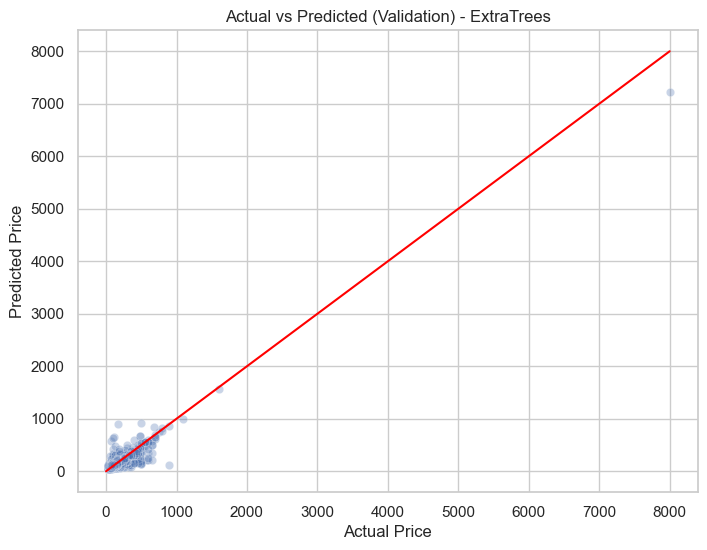

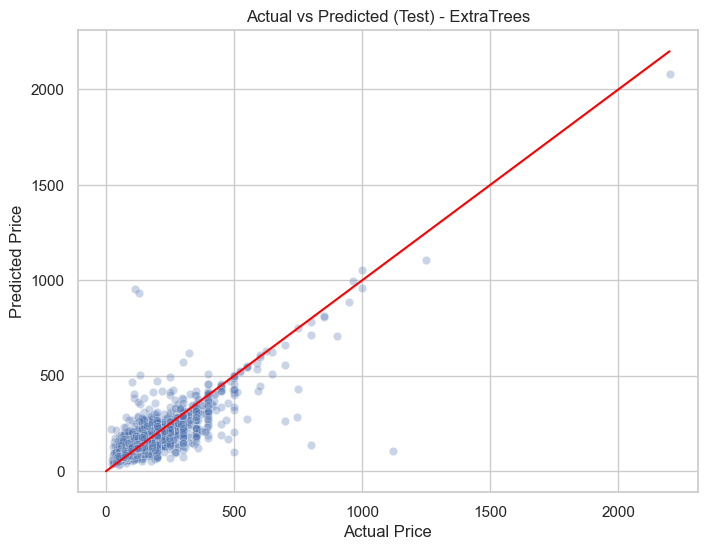

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Validation
y_pred_val = best_model.predict(X_val)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.3)
plt.plot([0, max(y_val)], [0, max(y_val)], color="red")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted (Validation) - {best_model_name}")
plt.show()

# Test
y_pred_test = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], color="red")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted (Test) - {best_model_name}")
plt.show()


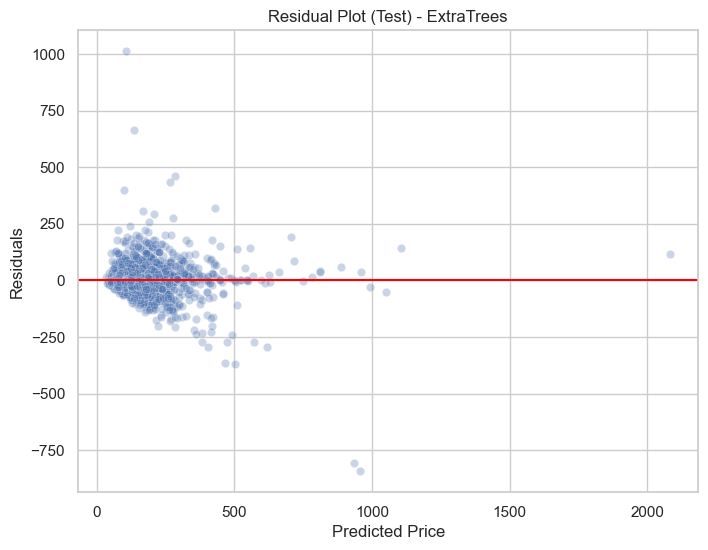

In [33]:
residuals = y_test - y_pred_test

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.3)
plt.axhline(0, color="red")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title(f"Residual Plot (Test) - {best_model_name}")
plt.show()


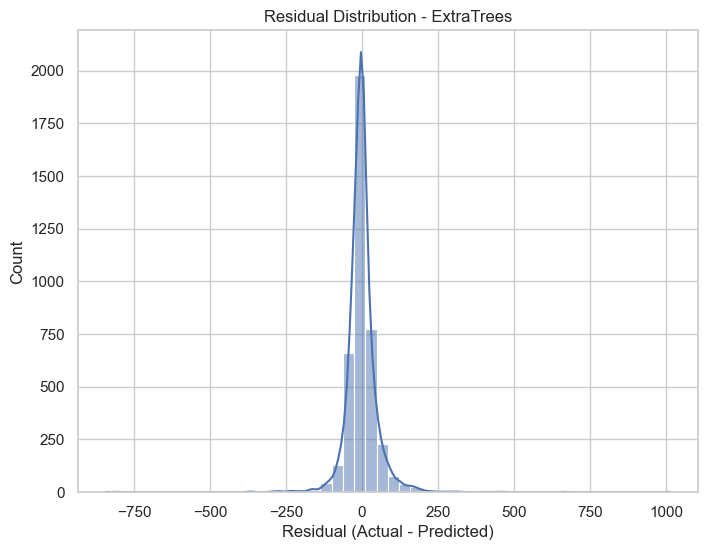

In [34]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title(f"Residual Distribution - {best_model_name}")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()


In [35]:

summary_df = pd.DataFrame(results_val).T
summary_df


,rmse,mae,r2
Ridge,73.314860,40.436850,0.772035
GradientBoosting,72.606693,34.576159,0.776417
SVR,143.985656,41.394105,0.120728
ExtraTrees,54.322139,30.504598,0.874848
Stacking,58.001914,35.176224,0.857318
